![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/4.3.Clinical_Deidentification_Comparison.ipynb)

# Comparison of different Deidentification Libraries
Out-of-the-box, without customization


image.png


In this notebook we will include a comparison of the deidentification capabilities of different libraries on 100 random clinical notes taken from [n2C2 Deidentification](https://portal.dbmi.hms.harvard.edu/projects/n2c2-nlp/) dataset.

We are just taking into account all the capabilities the libraries offer **without needing to do any further training, finetuning or defining in-house rules.**

The tested libraries are:
- [Spark NLP for Healthcare](https://nlp.johnsnowlabs.com/) ([clinical_deidentification](https://https://nlp.johnsnowlabs.com/2021/06/08/clinical_deidentification_glove_en.html) pipeline with Glove Embeddings)
- [AWS Comprehend Medical "detect_phi"](https://docs.aws.amazon.com/comprehend-medical/latest/dev/textanalysis-phi.html) API call
- [Microsoft Azure Cognitive Services "recognize_pii_entities"](https://docs.microsoft.com/en-us/rest/api/cognitiveservices-textanalytics/3.1preview4/entities-recognition-pii/entities-recognition-pii) API call. NOTE: This endpoint was not sufficient to cover all entities and we needed to add `recognize_entities` from the `Azure` client.
- [Google Cloud Platform Data Loss Prevention](https://cloud.google.com/dlp/docs/deidentify-sensitive-data) API call. NOTE: This endpoint was not sufficient and we needed to add `analyze_entities` from `LanguageServiceClient`.

# IMPORTANT NOTES TO CONSIDER BEFORE MOVING FORWARD
1. All libraries tested here have different tags. A map of entities is provided.
2. All libraries have different annotations guidelines, so we have considered as value *fuzzy matches*, with similarity bigger than the 60% of the annotated by JSL chunk (For some APIs, the chunk "Children Care Clinic" is detected including the word "Clinic", for others only proper names ("Children Care"). Both may be valid, they just depend on the [annotation guidelines](https://https://www.johnsnowlabs.com/inter-annotator-agreement-charts-transfer-learning-training-without-license-custom-training-script-with-annotation-lab/)).
3. All libraries have **customization** capabilities, that mean you can get much better results if you use some in-house knowledge, rule-based approach or finetunning. However, the aim of this benchmark is to check **OUT OF THE BOX** capabilities without any customization.
4. All libraries have more labels that the ones we included here, we just got a sample of 8 representative labels (`ID, DATE, HOSPITAL, LOCATION, AGE, PATIENT, DOCTOR, PHONE`)
5. Only SparkNLP and AWS had a good coverage of all the tags. Azure and GCP needed a combination of the PHI endpoint + a commong NER for detecting other entities (as Locations, Names, etc)

# Labels available in each API
Not all the API have the same specificity using labels. Some of them use more high-level tags (for example, `NAME` for both *Doctor* and *Patient* names, or `LOCATION` *City*, *ZIP*, even *Hospital*) but some others go low-level, so you can be able to differentiate between Doctors and Patients, what we should appreaciate.

The more **specificity** - the better, because as a rule of thumb, the more specific the less accurate you usually are: detecting `NAME` is evidently *easier* than *detecting* and *asserting* if that name is a `Doctor`'s name or a `Patient`'s name. 

Same happens with LOCATIONS and subentities (Street, City, etc) and many other tasks.

Our reference is the annotated labels by _JSL in-house medical annotators_. **Their total amount is 8**.

You can see the rest of API labels in the following table:

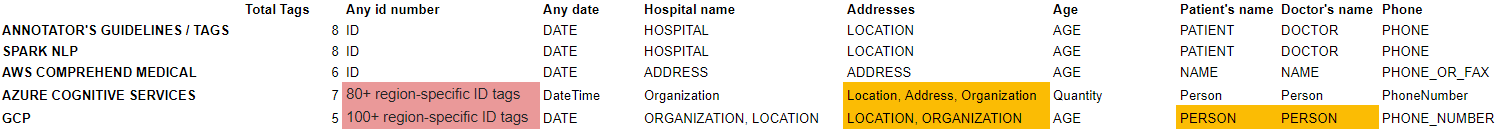

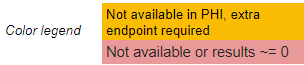

## Which is the most specific library?
The most specific library is **Spark NLP for Healthcare**, since it's the only one able to distinguish between a Patient and a Doctor Name, a Hospital and other Organizations or Addresses, etc.

This does not say anything about the accuracy of those tags. At the end of the day, you can have just one tag **NAME** or **LOCATION** and be able to detect all patients vs doctors, or organizations vs hospitals.

However, just imagine you want to mas or obfuscate the **Hospital** name. If you detect it as *ORGANIZATION** you may mask it as **ORG** and obfuscate it as "McDonalds". It is much better to be aware it's a Hospital and obfuscate is as **Mt. Sinai** instead.

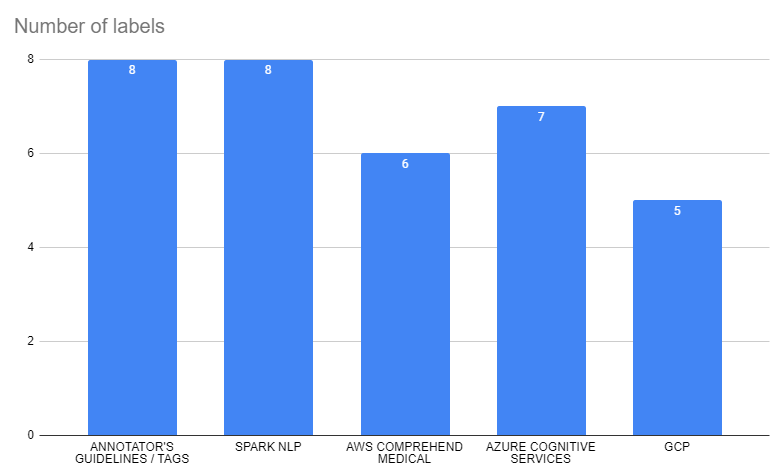

# Which has the best out-of-the-box performance?
Here is the performance for the 8 annotated tags by in-house JSL medical annotators.

NOTE1: all the API have different specificity. That means that, for Spark NLP, a Hospital will be detected as "**HOSPITAL**" but for Azure it may be an "**Organization**". We need to be **permissive** because different guidelines were applied when training those models in the different providers.

```
{
    'DATE': ['DATE', 'DateTime', 'DATE_OF_BIRTH'],
    'ID': ['ID', 'MEDICALRECORD', 'SocialNumber', 'IDNUM'],
    'AGE': ['AGE', 'Quantity'],
    'PHONE': ['PHONE', 'PHONE_OR_FAX', 'PhoneNumber'],
    'DOCTOR': ['DOCTOR', 'NAME', 'Person'],
    'PATIENT': ['PATIENT', 'NAME', 'Person'],
    'HOSPITAL': ['HOSPITAL', 'ADDRESS', 'Organization', 'Address', 'ORGANIZATION'],
    'LOCATION': ['LOCATION', 'ADDRESS', 'Address', 'STATE', 'COUNTRY', 'STREET', 'CITY']
}
```

The results show that, for the *100 clinical notes* of *n2c2 corpus*, the most accurate model is the one from **Spark NLP For Healthcare**, followed very closely by **AWS Comprehend Medical**.

Also, **Spark NLP** is the most specific of them all.

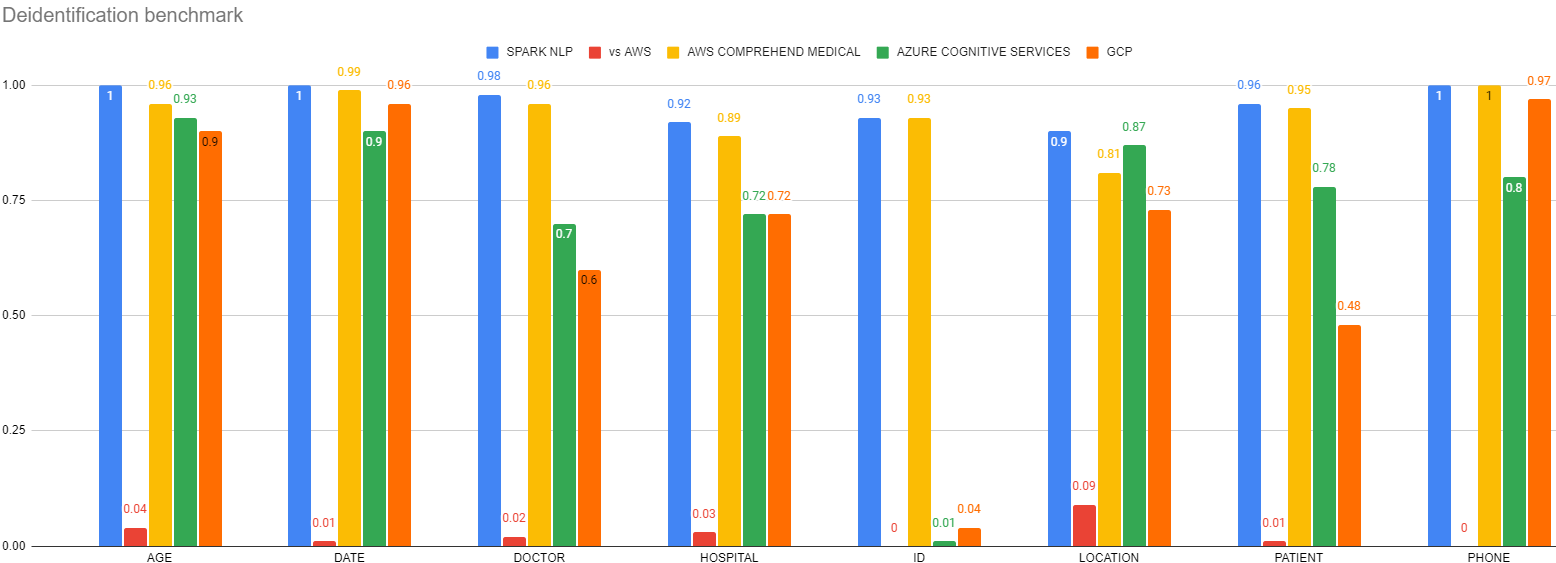

Now that we have seen the high-level picture, let's see the advantages and disadvantages of all of them

## Spark NLP
- Best accuracy
- Best specificity: very granular entities
- Can be augmented with Spark NLP NER models and rule-based components
- Can run in air-gapped environments
- License model: pay a license and use as much as you need

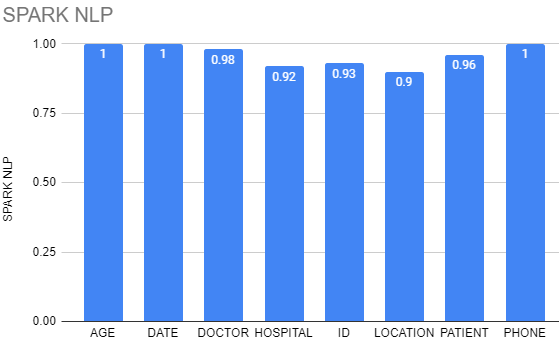

## AWS Comprehend Medical
- Very good accuracy
- Average level of granularity
- Big catalog of entities
- SaSS model: pay per API call

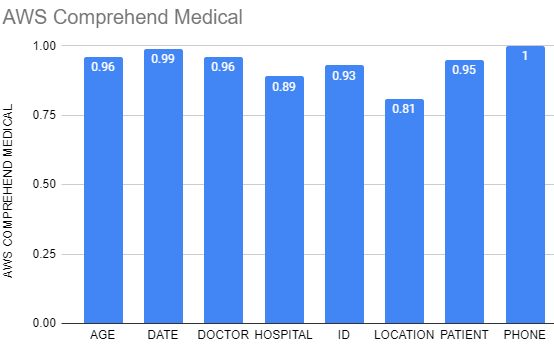

## Azure Cognitive Services
- Average accuracy
- Strange behavious, for example if we don't know the country of the document, it was returning Specific SSN and Income codes from New Zeland. Setting country specific labels didn't work. 
- We needed to use also generic ner to complement LOCATION and PATIENT / DOCTOR, since the recall for Person Names and Places (including Hospitals) was very low.
- Granular entities
- Many entities available in the catalogue, focus on country-region specific
- SaSS: pay per API call
- Almost no ID detected even after adding different generic and PHI specific endpoints

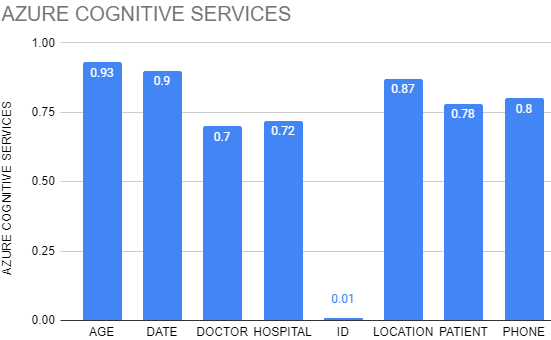

## Google Cloud Platform: Data Loss Prevention (DLP)
- Good accuracy for some tags
- It requires some previous configuration, default tags were not properly detecting basic tags as names or locations
- We needed to use also generic ner to complement LOCATION and PATIENT / DOCTOR, since the recall for Person Names and Places (including Hospitals) was very low.
- More entities available in the catalog, focus on country-region specific
- SaSS: pay per API call
- Almost no ID detected even after adding different generic and PHI specific endpoints

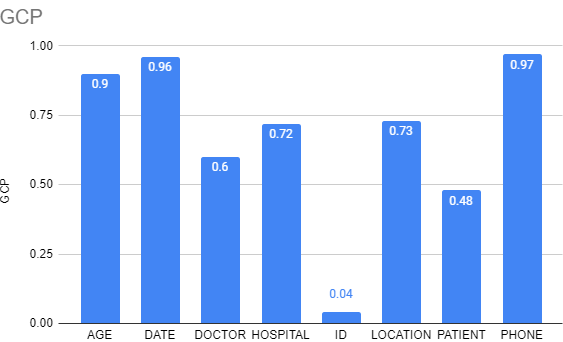

```        
        SPARK NLP    AWS    AZURE      GCP
AGE	      1	   0.96	0.93	  0.9
DATE	     1       0.99	0.9	   0.96
DOCTOR	   0.98    0.96	0.7	   0.6
HOSPITAL 	0.92    0.89	0.72	  0.72
ID	       0.93    0.93	0.01	  0.04
LOCATION 	0.9     0.81	0.87      0.73
PATIENT	  0.96    0.95	0.78      0.48
PHONE	    1       1	   0.8       0.97
```

# AGGREGATED METRICS

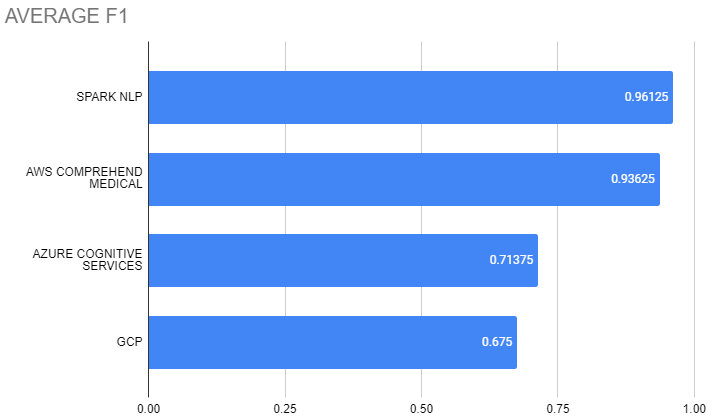

# LET US BEGIN !

# Download some clinical notes from N2C2

In [ ]:
!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/tutorials/Certification_Trainings/Healthcare/data/deid_surrogate_test_all_groundtruth_version2.xml

--2022-03-24 13:07:16--  https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/tutorials/Certification_Trainings/Healthcare/data/deid_surrogate_test_all_groundtruth_version2.xml
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/deid_surrogate_test_all_groundtruth_version2.xml [following]
--2022-03-24 13:07:16--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/deid_surrogate_test_all_groundtruth_version2.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting 

# Parsing the XML

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('deid_surrogate_test_all_groundtruth_version2.xml')
root = tree.getroot()

# Retrieving texts and PHI fields

In [ ]:
import re
data = []
for r in root.findall('RECORD'):
    for t in r.findall('TEXT'):
        children = []
        for c in t.getchildren():
            children.append((c.text, c.attrib['TYPE']))
        text = "".join([ t.text ] + [ ET.tostring(e).decode('utf-8') for e in t.getchildren()])
        unmasked_text = re.sub(r"<PHI [^>]*>", "", text)
        unmasked_text = re.sub(r"</PHI>", "", unmasked_text)
        data.append({'unmasked_text': unmasked_text, 'text': text, 'phi': children})

In [ ]:
len(data)

220

In [ ]:
# Printing data[0], that contains the information of the first clinical note.
print(data[0]['unmasked_text'])


113416550
PRGH
13523357
630190
6/7/1999 12:00:00 AM
Discharge Summary
Signed
DIS
Admission Date :
06/07/1999
Report Status :
Signed
Discharge Date :
06/13/1999
HISTORY OF PRESENT ILLNESS :
Essentially , Mr. Cornea is a 60 year old male who noted the onset of dark urine during early January .
He underwent CT and ERCP at the Lisonatemi Faylandsburgnic, Community Hospital with a stent placement and resolution of jaundice .
He underwent an ECHO and endoscopy at Ingree and Ot of Weamanshy Medical Center on April 28 .
He was found to have a large , bulging , extrinsic mass in the lesser curvature of his stomach .
Fine needle aspiration showed atypical cells , positively reactive mesothelial cells .
Abdominal CT on April 14 , showed a 12 x 8 x 8 cm mass in the region of the left liver , and appeared to be from the lesser curvature of the stomach or left liver .
He denied any nausea , vomiting , anorexia , or weight loss .
He states that his color in urine or in stool is now normal .
PAST MED

In [ ]:
print(data[0]['phi'])

[('113416550', 'ID'), ('PRGH', 'HOSPITAL'), ('13523357', 'ID'), ('630190', 'ID'), ('6/7', 'DATE'), ('06/07', 'DATE'), ('06/13', 'DATE'), ('Cornea', 'PATIENT'), ('January', 'DATE'), ('Lisonatemi Faylandsburgnic, Community Hospital', 'HOSPITAL'), ('Ingree and Ot of Weamanshy Medical Center', 'HOSPITAL'), ('April 28', 'DATE'), ('April 14', 'DATE'), ('7th of June', 'DATE'), ('Kotefooksshuff', 'DOCTOR'), ('THAMETO DOYLE', 'DOCTOR'), ('OS43', 'ID'), ('PRO R. KOTEFOOKSSHUFF', 'DOCTOR'), ('RF6 ZY525/1920', 'ID'), ('69874', 'ID'), ('YFKAJTRZX9', 'ID'), ('06/13', 'DATE'), ('06/13', 'DATE'), ('KE9', 'ID')]


# BENCHMARK PREPARATION

In [ ]:
import random
CLINICAL_NOTES = 100
RANDOM_SEED = 0.1

## Shuffling

In [ ]:
f_seed = lambda: RANDOM_SEED
random.shuffle(data, f_seed)
data = data[:100]
len(data)

100

In [ ]:
data[0]['phi']

[('929334185', 'ID'),
 ('FIH', 'HOSPITAL'),
 ('8151167', 'ID'),
 ('53653/y9m1', 'ID'),
 ('539442', 'ID'),
 ('5/13', 'DATE'),
 ('5/13', 'DATE'),
 ('5/16', 'DATE'),
 ('July', 'DATE'),
 ('July', 'DATE'),
 ('July', 'DATE'),
 ('November', 'DATE'),
 ('September 1', 'DATE'),
 ('November 5', 'DATE'),
 ('September', 'DATE'),
 ('05', 'DATE'),
 ('May 14', 'DATE'),
 ('May 15', 'DATE'),
 ('Douet', 'PATIENT'),
 ('Wires', 'DOCTOR'),
 ('Wires', 'DOCTOR'),
 ('526-6508', 'PHONE'),
 ('May 16', 'DATE'),
 ('Wires', 'DOCTOR'),
 ('Caslighlourdes', 'DOCTOR'),
 ('STIE FYFE', 'DOCTOR'),
 ('RIEMIND CASLIGHLOURDES', 'DOCTOR'),
 ('iv / bmot', 'DOCTOR'),
 ('5/16', 'DATE'),
 ('05/17', 'DATE')]

In [ ]:
import json
with open('100n2c2.json', 'w') as f:
  f.write(json.dumps(data))

In [ ]:
# 1 text per line
with open('100n2c2_texts.json', 'w') as f:
  f.write(json.dumps([{'text': x['unmasked_text']} for x in data]))

# Spark NLP for Healthcare
Let's use Spark NLP for Healthcare's Pretrained Pipeline for `clinical_deidentification`

## License

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
import os
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare-3.4.1.json to spark_nlp_for_healthcare-3.4.1.json


In [ ]:
# Installing pyspark and spark-nlp
!pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

     |████████████████████████████████| 212.4 MB 63 kB/s 
     |████████████████████████████████| 140 kB 20.2 MB/s 
     |████████████████████████████████| 198 kB 59.6 MB/s 


In [ ]:
# Installing Spark NLP Healthcare
!pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

     |████████████████████████████████| 147 kB 7.4 MB/s 


## Starting a Spark NLP for Healthcare session

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

import warnings
import pprint 
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.4.1
Spark NLP_JSL Version : 3.4.1


In [ ]:
from sparknlp.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("clinical_deidentification_glove_augmented", "en", "clinical/models")

clinical_deidentification_glove_augmented download started this may take some time.
Approx size to download 172.9 MB
[OK!]


## `annotate()` on PretrainedPipelines uses LightPipelines, what means is optimized for speed

In [ ]:
%%time
res = []
for d in data:
  x = deid_pipeline.annotate(d['unmasked_text'])
  res.append(x)

CPU times: user 2.94 s, sys: 961 ms, total: 3.9 s
Wall time: 3min 7s


In [ ]:
with open('sparknlp_res_xx.json', 'w') as f:
  f.write(json.dumps(res))

# AWS Comprehend Medical

In [ ]:
!pip install botocore boto3

In [ ]:
ACCESS_KEY = 'ADD ME'
SECRET_KEY = 'ADD ME'

In [ ]:
from botocore.vendored import requests
import json
import boto3
import logging
import threading
client = boto3.client(region_name='us-west-2', service_name='comprehendmedical', aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY)

def extract_entities_from_message(message):
    return client.detect_phi(Text=message)

In [ ]:
res = []
for d in data:
  res.append(extract_entities_from_message(d['unmasked_text']))

In [ ]:
with open('aws_res.json', 'w') as f:
  f.write(json.dumps(res))

# Azure Cognitive Services

## Deid Model Annotations

In [ ]:
!pip install azure-ai-textanalytics==5.1.0

In [ ]:
import math
key = "ADD ME"
endpoint = "https://cstest2.cognitiveservices.azure.com/"

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

MAX_LENGTH = 5120

# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

# Example method for detecting sensitive information (PII) from text
def pii_recognition_example(client, text):
  parts = math.ceil(len(text) / MAX_LENGTH)
  parts_text = []
  for i in range(0, parts):
    part = text[MAX_LENGTH*i:MAX_LENGTH*(i+1)]
    res = client.recognize_pii_entities([part], language="en")
    parts_text.append(res)
  return parts_text

def ner(client, text):
  parts = math.ceil(len(text) / MAX_LENGTH)
  parts_text = []
  for i in range(0, parts):
    part = text[MAX_LENGTH*i:MAX_LENGTH*(i+1)]
    res = client.recognize_entities([part], language="en")
    parts_text.append(res)
  return parts_text

In [ ]:
results = []
for d in data:
  results.append(pii_recognition_example(client, d['unmasked_text']))

In [ ]:
results

[[[RecognizePiiEntitiesResult(id=0, entities=[PiiEntity(text=929334185, category=PhoneNumber, subcategory=None, length=9, offset=1, confidence_score=0.8), PiiEntity(text=FIH, category=Organization, subcategory=None, length=3, offset=11, confidence_score=0.89), PiiEntity(text=5/13/1994 12:00:00 AM, category=DateTime, subcategory=None, length=21, offset=41, confidence_score=0.8), PiiEntity(text=DIS, category=Organization, subcategory=Sports, length=3, offset=96, confidence_score=0.73), PiiEntity(text=5/13/94, category=DateTime, subcategory=Date, length=7, offset=142, confidence_score=0.8), PiiEntity(text=5/16/94, category=DateTime, subcategory=Date, length=7, offset=167, confidence_score=0.8), PiiEntity(text=69 year-old, category=Quantity, subcategory=Age, length=11, offset=360, confidence_score=0.8), PiiEntity(text=July of 1993, category=DateTime, subcategory=DateRange, length=12, offset=406, confidence_score=0.8), PiiEntity(text=10 minutes, category=DateTime, subcategory=Duration, leng

In [ ]:
res = []
for doc in results:
  x = dict()
  x['redacted'] = ''
  entities = []
  flat_subdoc = [item for sublist in doc for item in sublist]
  for subdoc in flat_subdoc:
    x['redacted'] += subdoc.redacted_text    
    for entity in subdoc.entities:
      y = dict()
      y['entity'] = entity.text
      y['category'] = entity.category
      y['confidence'] = entity.confidence_score
      y['offset'] = entity.offset
      y['length'] = entity.length
      entities.append(y)
  x['entities'] = entities
  res.append(x)

In [ ]:
with open('azure_res.json', 'w') as f:
  f.write(json.dumps(res))

In [ ]:
len(res)

100

## NER Model Annotations

In [ ]:
# Getting annotations from NER model for LOCATION entities
results = []
for d in data:
  results.append(ner(client, d['unmasked_text']))

In [ ]:
res = []
for doc in results:
  x = dict()
  # x['redacted'] = ''
  entities = []
  flat_subdoc = [item for sublist in doc for item in sublist]
  for subdoc in flat_subdoc:
    # x['redacted'] += subdoc.redacted_text    
    for entity in subdoc.entities:
      y = dict()
      y['entity'] = entity.text
      y['category'] = entity.category if entity.category == 'Location' else 'NULL'
      y['confidence'] = entity.confidence_score
      y['offset'] = entity.offset
      y['length'] = entity.length
      entities.append(y)
  x['entities'] = entities
  res.append(x)

In [ ]:
with open('azure_res_location.json', 'w') as f:
  f.write(json.dumps(res))

In [ ]:
len(res)

100

# GCP (Google Cloud Provider)

## Deid Model Annotations

In [ ]:
!pip install google-cloud

In [ ]:
import requests

In [ ]:
import json
GCP_KEY = {
  "type": "service_account",
  "project_id": "ADD ME",
  "private_key_id": "ADD ME",
  "private_key": "ADD ME",
  "client_email": "ADD ME",
  "client_id": "ADD ME",
  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
  "token_uri": "https://oauth2.googleapis.com/token",
  "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
  "client_x509_cert_url": "ADD ME"
}
with open('./gcp_key.json', 'w') as f:
  json.dump(GCP_KEY, f)

In [ ]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/gcp_key.json"

In [ ]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/gcp_key.json


In [ ]:
!pip install google-cloud-dlp
import google.cloud.dlp

In [ ]:
import time

def inspect_string(
    project,
    content_string,
    info_types=[],
    custom_dictionaries=None,
    custom_regexes=None,
    min_likelihood=None,
    max_findings=None,
    include_quote=True,
):
    """Uses the Data Loss Prevention API to analyze strings for protected data.
    Args:
        project: The Google Cloud project id to use as a parent resource.
        content_string: The string to inspect.
        info_types: A list of strings representing info types to look for.
            A full list of info type categories can be fetched from the API.
        min_likelihood: A string representing the minimum likelihood threshold
            that constitutes a match. One of: 'LIKELIHOOD_UNSPECIFIED',
            'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE', 'LIKELY', 'VERY_LIKELY'.
        max_findings: The maximum number of findings to report; 0 = no maximum.
        include_quote: Boolean for whether to display a quote of the detected
            information in the results.
    Returns:
        None; the response from the API is printed to the terminal.
    """

    # Import the client library.
    import google.cloud.dlp

    # Instantiate a client.
    dlp = google.cloud.dlp_v2.DlpServiceClient()

    # Prepare info_types by converting the list of strings into a list of
    # dictionaries (protos are also accepted).
    info_types = [{"name": info_type} for info_type in info_types]

    # Construct the configuration dictionary. Keys which are None may
    # optionally be omitted entirely.
    inspect_config = {
        "info_types": info_types,
        # "custom_info_types": custom_info_types,
        "min_likelihood": min_likelihood,
        "include_quote": include_quote,
        "limits": {"max_findings_per_request": max_findings},
    }

    # Construct the `item`.
    item = {"value": content_string}

    # Convert the project id into a full resource id.
    parent = f"projects/{project}"

    # Call the API.
    response = dlp.inspect_content(
        request={"parent": parent, "inspect_config": inspect_config, "item": item}
    )

    return response

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
# Get Azure labels for ID
lang_page = requests.get('https://cloud.google.com/dlp/docs/infotypes-reference')
soup = BeautifulSoup(lang_page.content, 'html.parser')
codes = soup.find_all('code')
orgs = [l.get_text() for l in codes]
# id_cat = [i for i in orgs if ('ID' in i) or ('Number' in i)]
id_cat = list(set(orgs))
cleaned_list = [x for x in id_cat if (x!='GCP_CREDENTIALS')&(x!='ICD9_CODE')&(x!='DOMAIN_NAME')&(x!='TIME')&(x!='CREDIT_CARD_NUMBER')&(x!='JSON_WEB_TOKEN')&(x!='DOCUMENT_TYPE/R&D/DATABASE_BACKUP')&(x!='DOMAIN_NAME')&(x!='STORAGE_SIGNED_URL')&(x!='DOCUMENT_TYPE/LEGAL/LAW')&(x!='URL')&(x!='STORAGE_SIGNED_POLICY_DOCUMENT')&(x!='WEAK_PASSWORD_HASH')&(x!='GCP_API_KEY')&(x!='DOCUMENT_TYPE/LEGAL/COURT_ORDER')&(x!='ENCRYPTION_KEY')&(x!='ENCRYPTION_KEY')&(x!='HTTP_COOKIE')&(x!='EMAIL_ADDRESS')&(x!='DOCUMENT_TYPE/HR/RESUME')&(x!='IMEI_HARDWARE_ID')&(x!='XSRF_TOKEN')&(x!='FDA_CODE')&(x!='MEDICAL_TERM')&(x!='GENDER')&(x!='AWS_CREDENTIALS')&(x!='MAC_ADDRESS')&(x!='AZURE_AUTH_TOKEN')&(x!='DOCUMENT_TYPE/R&D/SYSTEM_LOG')&(x!='DOCUMENT_TYPE/LEGAL/PLEADING')&(x!='PASSWORD')&(x!='ICD10_CODE')&(x!='AUTH_TOKEN')&(x!='BASIC_AUTH_HEADER')&(x != 'DOCUMENT_TYPE/LEGAL/BRIEF') and (x != 'IBAN_CODE') and (x != 'ETHNIC_GROUP')and (x != 'DOCUMENT_TYPE/LEGAL/BLANK_FORM')and (x != 'DOCUMENT_TYPE/R&D/SOURCE_CODE')and (x != 'DOCUMENT_TYPE/FINANCE/SEC_FILING') and (x != 'infoTypes.list')]

In [ ]:
gcp_anns = []

for i, d in enumerate(data):
  res = inspect_string(GCP_KEY['project_id'], d['unmasked_text'], info_types=cleaned_list)  
  gcp_entities = []
  # Print out the results.
  if res.result.findings:
    for finding in res.result.findings:
      ent = {}
      try:
          ent['quote'] = finding.quote
          ent['entity'] = finding.info_type.name
          ent['start'] = finding.location.codepoint_range.start
          ent['end'] = finding.location.codepoint_range.end
          gcp_entities.append(ent)
      except AttributeError:
          pass
  gcp_anns.append({'original_text': d['unmasked_text'], 'entities': gcp_entities})  
  time.sleep(20)

In [ ]:
len(gcp_anns)

100

In [ ]:
with open('./gcp_res.json', 'w') as f:
  f.write(json.dumps(gcp_anns))

## NER Model Annotations

In [ ]:
!pip install google-cloud-language

In [ ]:
import json
GCP_KEY = {
  "type": "service_account",
  "project_id": "ADD ME",
  "private_key_id": "ADD ME",
  "private_key": "ADD ME",
  "client_email": "ADD ME",
  "client_id": "ADD ME",
  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
  "token_uri": "https://oauth2.googleapis.com/token",
  "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
  "client_x509_cert_url": "ADD ME"
}
with open('./gcp_key.json', 'w') as f:
  json.dump(GCP_KEY, f)

In [ ]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/gcp_key.json"

In [ ]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/gcp_key.json


In [ ]:
from google.cloud import language_v1
from google.cloud.language_v1 import enums

def gcp_ner(document):
    client = language_v1.LanguageServiceClient()
    encoding_type = enums.EncodingType.UTF8
    
    # Get entities from the document
    response = client.analyze_entities(document, encoding_type=encoding_type)
    return response

In [ ]:
# GCP regular NER model
gcp_anns_ner = []

import time
for i, d in enumerate(data):
  res = gcp_ner(document = {"content": d['unmasked_text'], "type": enums.Document.Type.PLAIN_TEXT, "language": "en"})
  gcp_entities = []
  # Print out the results.
  if res.entities:
    for finding in res.entities:
      ent = {}
      try:
          ent['quote'] = finding.mentions[0].text.content
          ent['entity'] = enums.Entity.Type(finding.type).name
          ent['start'] = finding.mentions[0].text.begin_offset
          ent['end'] = int(finding.mentions[0].text.begin_offset) + len(finding.mentions[0].text.content)
          gcp_entities.append(ent)
      except AttributeError:
          pass
  gcp_anns_ner.append({'original_text': d['unmasked_text'], 'entities': gcp_entities})  
  time.sleep(5)

In [ ]:
len(gcp_anns_ner)

100

In [ ]:
with open('./gcp_res_ner.json', 'w') as f:
  f.write(json.dumps(gcp_anns_ner))

# BENCHMARK

# Load annotated data by JSL and texts

In [ ]:
!wget https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/tutorials/Certification_Trainings/Healthcare/data/annotations.json

--2022-03-24 14:58:03--  https://github.com/JohnSnowLabs/spark-nlp-workshop/raw/master/tutorials/Certification_Trainings/Healthcare/data/annotations.json
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/annotations.json [following]
--2022-03-24 14:58:03--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/annotations.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322996 (1.3M) [text/plain]
Saving to: ‘annotations.json’

annotation

In [ ]:
import json
with open('annotations.json', 'r') as f:
  annotations = json.load(f)

In [ ]:
annotations = sorted(annotations, key=lambda x: x['id'])

In [ ]:
import json
with open('100n2c2_texts.json', 'r') as f:
  texts = json.load(f)

In [ ]:
annotations[0]['data']['text']

"\n929334185\nFIH\n8151167\n53653/y9m1\n539442\n5/13/1994 12:00:00 AM\nHYPOPHARYNGEAL CANCER .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n5/13/94\nDISCHARGE DATE :\n5/16/94\nPRINCIPAL DIAGNOSIS :\nHypopharyngeal cancer .\nPRINCIPAL PROCEDURE :\nRemoval of left neck lymph node and esophageal endoscopy and dilation .\nHISTORY AND REASON FOR ADMISSION :\nThis is a 69 year-old white male status post surgery in July of 1993 for a laryngopharyngoesophagogastrectomy with gastric reconstruction and modified right neck dissection for pharyngeal cancer .\nSince that surgery , the patient has had dysphagia off and on , solids worse than liquids .\nSometimes solids get stuck for about 10 minutes .\nAbout two months ago the patient had come to the emergency room because he couldn 't swallow for three days .\nHe required esophageal dilation .\nAlso , since July the patient has noted bilateral lymphadenopathy , especially the large submandibular , which has gotten larger .\nIt is di

In [ ]:
texts[0]['text']

"\n929334185\nFIH\n8151167\n53653/y9m1\n539442\n5/13/1994 12:00:00 AM\nHYPOPHARYNGEAL CANCER .\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n5/13/94\nDISCHARGE DATE :\n5/16/94\nPRINCIPAL DIAGNOSIS :\nHypopharyngeal cancer .\nPRINCIPAL PROCEDURE :\nRemoval of left neck lymph node and esophageal endoscopy and dilation .\nHISTORY AND REASON FOR ADMISSION :\nThis is a 69 year-old white male status post surgery in July of 1993 for a laryngopharyngoesophagogastrectomy with gastric reconstruction and modified right neck dissection for pharyngeal cancer .\nSince that surgery , the patient has had dysphagia off and on , solids worse than liquids .\nSometimes solids get stuck for about 10 minutes .\nAbout two months ago the patient had come to the emergency room because he couldn 't swallow for three days .\nHe required esophageal dilation .\nAlso , since July the patient has noted bilateral lymphadenopathy , especially the large submandibular , which has gotten larger .\nIt is di

Check that annotated texts correspond to the original texts

In [ ]:
assert texts[0]['text'] == annotations[0]['data']['text']

In [ ]:
assert texts[99]['text']  == annotations[99]['data']['text']

# Creating Annotation Named Tuple

In [ ]:
import collections

Annotation = collections.namedtuple('Annotation', 'start end label text')

# Creating ground truth

In [ ]:
ann_tuples = []
for annotation in annotations:
  for completion in annotation['completions']:
    text_ann = []
    for result in completion['result']:
      tup = Annotation(result['value']['start'], result['value']['end'], result['value']['labels'][0], result['value']['text'])
      text_ann.append(tup)
  ann_tuples.append(text_ann)

# Creating labels synonyms through different APIs
Keys: Ground truth labels
Values: Label names in different APIs

In [ ]:
label_maps = {
    'DATE': ['DATE', 'DateTime', 'DATE_OF_BIRTH'],
    'ID': ['ID', 'MEDICALRECORD', 'IDNUM'],
    'AGE': ['AGE', 'Quantity'],
    'PHONE': ['PHONE', 'PHONE_OR_FAX', 'PhoneNumber', 'PHONE_NUMBER', 'CONTACT'],
    'DOCTOR': ['DOCTOR', 'NAME', 'Person', 'PERSON_NAME', 'PATIENT', 'USERNAME'],
    'PATIENT': ['PATIENT', 'NAME', 'Person', 'PERSON_NAME', 'DOCTOR', 'USERNAME'],
    'HOSPITAL': ['HOSPITAL', 'ADDRESS', 'Organization', 'Address', 'ORGANIZATION', 'LOCATION'],
    'LOCATION': ['LOCATION', 'ADDRESS', 'Address', 'Location', 'Organization', 'STATE', 'COUNTRY', 'STREET', 'CITY', 'HOSPITAL']}

In [ ]:
import math
def is_same_label(api_label, label):
  api_label_mod = api_label.replace("{","")
  api_label_mod = api_label_mod.replace("}","")
  api_label_mod = api_label_mod.replace("[","")
  api_label_mod = api_label_mod.replace("]","")
  api_label_mod = api_label_mod.replace("<","")
  api_label_mod = api_label_mod.replace(">","")
  return api_label_mod in label_maps[label]

def is_sim_pos(pos1, pos2):
  # Different tokenization rules may bring to displacement. I consider a 10% of span
  diff = int(pos1) * 0.1
  return abs(pos1 - pos2) <= diff

def is_sim_text(text1, text2):
  return (text1.strip() in text2.strip()) or (text2.strip() in text1.strip()) or (Levenshtein.ratio(text1.strip(), text2.strip())>0.6)

# Creating Metrics
Different libraries have different annotation guidelines, so we won't go for an exact match, but for a fuzzy match

In [ ]:
!pip install levenshtein

     |████████████████████████████████| 258 kB 29.6 MB/s 
     |████████████████████████████████| 1.6 MB 45.3 MB/s 
     |████████████████████████████████| 103 kB 44.7 MB/s 


In [ ]:
import Levenshtein

# TP: Exact match and label (or equivalent in the map)
# TP (fuzzy match): Partial match and exact label (or equivalent in the map)
# FP: A label annotated by the Medical Annotator was labelled as something else by the model
# FN: A label annotated by the Medical Annotator was not labelled by the model

# NOTE: We are not considering as FP a tag detected by the model and not tagged by the annotator as this is usually done,
# since the models have all many different labels not considered in the Annotator's guidelines

# Calculates TP, FP and FN for 1 document
def get_doc_metrics(ann_tuples, res_tuples, print_fn=False, print_fp=False, verbose=None):
  metrics_dict = dict()
  for key in label_maps.keys():
    metrics_dict[key] = {'tp': 0, 'fp': 0, 'fn': 0}
  
  if res_tuples is None:
    return metrics_dict

  for ann_tuple in ann_tuples:
    checking = False
    if verbose is not None and verbose == ann_tuple.label:
      print("- Checking " + ann_tuple.label + " - " + ann_tuple.text)
      checking = True
    found = False
    if ann_tuple.label not in label_maps:
      continue
    for res_tuple in res_tuples:
      if checking:
        print("-- towards... " + res_tuple.label + " - " + res_tuple.text + "(" + str(is_sim_pos(ann_tuple.start, res_tuple.start)) + " " + str(ann_tuple.start) + "/" + str(res_tuple.start) + "," + str(is_sim_pos(ann_tuple.end, res_tuple.end)) + " " + str(ann_tuple.end) + "/" + str(res_tuple.end) + "," + str(is_same_label(res_tuple.label, ann_tuple.label)) + "," + str(is_sim_text(ann_tuple.text, res_tuple.text)) + ")")
      # Exact match
      if ann_tuple.start == res_tuple.start and ann_tuple.end == res_tuple.end and is_same_label(res_tuple.label, ann_tuple.label) and ann_tuple.text.strip() == res_tuple.text.strip():
        metrics_dict[ann_tuple.label]['tp']+=1
        if checking:
          print ("--- Exact match!")
        found = True
        break
      # Fuzzy match
      elif (is_sim_pos(ann_tuple.start, res_tuple.start) or is_sim_pos(ann_tuple.end, res_tuple.end)) and is_same_label(res_tuple.label, ann_tuple.label) and is_sim_text(ann_tuple.text, res_tuple.text):
        metrics_dict[ann_tuple.label]['tp']+=1
        if checking:
          print ("--- Fuzzy match!")
        found = True
        break
      # False Positives
      elif (is_sim_pos(ann_tuple.start, res_tuple.start) or is_sim_pos(ann_tuple.end, res_tuple.end)) and not is_same_label(res_tuple.label, ann_tuple.label) and is_sim_text(ann_tuple.text, res_tuple.text):
        metrics_dict[ann_tuple.label]['fp']+=1
        found = True
        if checking:
          print ("--- FP!")
        if print_fp:
          print(f"False Positive. Annotated: {ann_tuple.label} --> {ann_tuple.text}\t\tExtracted: {res_tuple.label} --> {res_tuple.text}")
        break
    # Missing annotation
    if not found:
      metrics_dict[ann_tuple.label]['fn']+=1
      if checking:
        print ("--- FN!")
      if print_fn:                 
          print(f"False Negative in {ann_tuple.id}. Annotated: {ann_tuple.label} --> {ann_tuple.text} not found")
  return metrics_dict

In [ ]:
# Calculates TP, FP and FN for all the documents
def get_all_doc_metrics(all_doc_ann, all_doc_res, print_fn=False, print_fp=False, verbose=None):
  if len(all_doc_ann) != len(all_doc_res):
    print("You should have the same number of annotations in ground truth and in API to evaluate")
    return None
  metrics_dict = dict()
  for key in label_maps.keys():
    metrics_dict[key] = {'tp': 0, 'fp': 0, 'fn': 0}

  for i in range(0, len(all_doc_ann)):
    res_dict = get_doc_metrics(all_doc_ann[i], all_doc_res[i], print_fn, print_fp, verbose)
    for k in metrics_dict.keys():
      for k2 in metrics_dict[key].keys():
        metrics_dict[k][k2] += res_dict[k][k2]
  return metrics_dict

In [ ]:
# PREC, REC and F1 calculations
def get_formula_metrics(metrics_dict):
  formula_metrics_dict = dict()
  for key in metrics_dict.keys():
    prec = 0
    if metrics_dict[key]['tp']+metrics_dict[key]['fp'] != 0:
      prec = metrics_dict[key]['tp'] / (metrics_dict[key]['tp']+metrics_dict[key]['fp'])
    rec = 0
    if metrics_dict[key]['tp']+metrics_dict[key]['fn'] != 0:
      rec = metrics_dict[key]['tp'] / (metrics_dict[key]['tp']+metrics_dict[key]['fn'])
    formula_metrics_dict[key] = {
        'prec': prec,
        'rec': rec,
        'f1': (2*rec*prec) / (rec + prec) if (rec + prec) != 0 else 0}
  return formula_metrics_dict  

# SparkNLP

In [ ]:
import json
with open('sparknlp_res_xx.json', 'r') as f:
  sparknlp_res = json.load(f)

In [ ]:
for i in range(0, len(sparknlp_res)):
  sparknlp_res[i]['original_text'] = texts[i]
  text = ""

In [ ]:
import re
sparknlp_tuples = []
for n, r in enumerate(sparknlp_res):
  tuples = []
  found_chunks = []
  masks = re.findall(r"<[A-Z_]+>", "\n".join(r['masked']))
  chunks = r['ner_chunk']
  if len(masks) != len(chunks):
    sparknlp_tuples.append(None)
    continue
  for i in range(0, len(chunks)):
    mask = masks[i]
    chunk = chunks[i]
    possible_spans = [(match.start(), match.end()) for match in re.finditer(f"[\n ]{re.escape(chunk)}[\n ]", r['original_text'])]
    position = found_chunks.count(chunk)
    if position >= len(possible_spans):
      continue
    start = possible_spans[position][0]
    end = possible_spans[position][1]
    found_chunks.append(chunk)
    tuples.append(Annotation(start, end, mask, chunk))
  sparknlp_tuples.append(tuples)

In [ ]:
sparknlp_tuples[0]

[Annotation(start=0, end=11, label='<MEDICALRECORD>', text='929334185'),
 Annotation(start=10, end=15, label='<HOSPITAL>', text='FIH'),
 Annotation(start=14, end=34, label='<MEDICALRECORD>', text='8151167\n53653/y9m1'),
 Annotation(start=33, end=41, label='<MEDICALRECORD>', text='539442'),
 Annotation(start=40, end=51, label='<DATE>', text='5/13/1994'),
 Annotation(start=141, end=150, label='<DATE>', text='5/13/94'),
 Annotation(start=166, end=175, label='<DATE>', text='5/16/94'),
 Annotation(start=359, end=363, label='<AGE>', text='69'),
 Annotation(start=405, end=419, label='<DATE>', text='July of 1993'),
 Annotation(start=405, end=411, label='<DATE>', text='July'),
 Annotation(start=845, end=851, label='<DATE>', text='July'),
 Annotation(start=1338, end=1355, label='<DATE>', text='November , 1994'),
 Annotation(start=1438, end=1458, label='<DATE>', text='September 1 , 1993'),
 Annotation(start=1570, end=1589, label='<DATE>', text='November 5 , 1994'),
 Annotation(start=1620, end=163

In [ ]:
sparknlp_dict = get_all_doc_metrics(ann_tuples, sparknlp_tuples)
sparknlp_dict

{'AGE': {'fn': 0, 'fp': 0, 'tp': 95},
 'DATE': {'fn': 5, 'fp': 1, 'tp': 944},
 'DOCTOR': {'fn': 12, 'fp': 5, 'tp': 381},
 'HOSPITAL': {'fn': 15, 'fp': 13, 'tp': 154},
 'ID': {'fn': 39, 'fp': 25, 'tp': 396},
 'LOCATION': {'fn': 5, 'fp': 4, 'tp': 38},
 'PATIENT': {'fn': 8, 'fp': 0, 'tp': 107},
 'PHONE': {'fn': 0, 'fp': 0, 'tp': 15}}

In [ ]:
get_formula_metrics(sparknlp_dict)

{'AGE': {'f1': 1.0, 'prec': 1.0, 'rec': 1.0},
 'DATE': {'f1': 0.996832101372756,
  'prec': 0.9989417989417989,
  'rec': 0.9947312961011591},
 'DOCTOR': {'f1': 0.9781771501925545,
  'prec': 0.9870466321243523,
  'rec': 0.9694656488549618},
 'HOSPITAL': {'f1': 0.9166666666666667,
  'prec': 0.9221556886227545,
  'rec': 0.9112426035502958},
 'ID': {'f1': 0.9252336448598132,
  'prec': 0.9406175771971497,
  'rec': 0.9103448275862069},
 'LOCATION': {'f1': 0.8941176470588236,
  'prec': 0.9047619047619048,
  'rec': 0.8837209302325582},
 'PATIENT': {'f1': 0.9639639639639639, 'prec': 1.0, 'rec': 0.9304347826086956},
 'PHONE': {'f1': 1.0, 'prec': 1.0, 'rec': 1.0}}

# AWS Medical Comprehend

In [ ]:
import json
with open('aws_res.json', 'r') as f:
  aws_res = json.load(f)

In [ ]:
aws_tuples = []
for doc in aws_res:
  tuples = []
  for res in doc['Entities']:
    tuples.append(Annotation(res['BeginOffset'], res['EndOffset'], res['Type'], res['Text']))
  aws_tuples.append(tuples)

In [ ]:
aws_tuples[0]

[Annotation(start=1, end=10, label='ID', text='929334185'),
 Annotation(start=15, end=22, label='ID', text='8151167'),
 Annotation(start=23, end=28, label='ID', text='53653'),
 Annotation(start=34, end=40, label='ID', text='539442'),
 Annotation(start=41, end=50, label='DATE', text='5/13/1994'),
 Annotation(start=142, end=149, label='DATE', text='5/13/94'),
 Annotation(start=167, end=174, label='DATE', text='5/16/94'),
 Annotation(start=360, end=362, label='AGE', text='69'),
 Annotation(start=406, end=418, label='DATE', text='July of 1993'),
 Annotation(start=738, end=752, label='ADDRESS', text='emergency room'),
 Annotation(start=1339, end=1354, label='DATE', text='November , 1994'),
 Annotation(start=1439, end=1457, label='DATE', text='September 1 , 1993'),
 Annotation(start=1571, end=1588, label='DATE', text='November 5 , 1994'),
 Annotation(start=1621, end=1637, label='DATE', text='September , 1993'),
 Annotation(start=2919, end=2921, label='AGE', text='69'),
 Annotation(start=2998

In [ ]:
aws_dict = get_all_doc_metrics(ann_tuples, aws_tuples)
aws_dict

{'AGE': {'fn': 6, 'fp': 1, 'tp': 88},
 'DATE': {'fn': 10, 'fp': 0, 'tp': 943},
 'DOCTOR': {'fn': 33, 'fp': 0, 'tp': 369},
 'HOSPITAL': {'fn': 34, 'fp': 3, 'tp': 145},
 'ID': {'fn': 29, 'fp': 34, 'tp': 402},
 'LOCATION': {'fn': 9, 'fp': 6, 'tp': 32},
 'PATIENT': {'fn': 11, 'fp': 0, 'tp': 104},
 'PHONE': {'fn': 0, 'fp': 0, 'tp': 15}}

In [ ]:
get_formula_metrics(aws_dict)

{'AGE': {'f1': 0.9617486338797814,
  'prec': 0.9887640449438202,
  'rec': 0.9361702127659575},
 'DATE': {'f1': 0.9947257383966245, 'prec': 1.0, 'rec': 0.9895068205666316},
 'DOCTOR': {'f1': 0.9571984435797666, 'prec': 1.0, 'rec': 0.917910447761194},
 'HOSPITAL': {'f1': 0.8868501529051988,
  'prec': 0.9797297297297297,
  'rec': 0.8100558659217877},
 'ID': {'f1': 0.9273356401384083,
  'prec': 0.9220183486238532,
  'rec': 0.9327146171693735},
 'LOCATION': {'f1': 0.810126582278481,
  'prec': 0.8421052631578947,
  'rec': 0.7804878048780488},
 'PATIENT': {'f1': 0.9497716894977168, 'prec': 1.0, 'rec': 0.9043478260869565},
 'PHONE': {'f1': 1.0, 'prec': 1.0, 'rec': 1.0}}

# Azure Cognitive Services

## Deid Model Results

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# Get Azure labels for ID
lang_page = requests.get('https://docs.microsoft.com/en-us/azure/cognitive-services/language-service/personally-identifiable-information/concepts/entity-categories')
soup = BeautifulSoup(lang_page.content, 'html.parser')
codes = soup.find_all('code')
orgs = [l.get_text() for l in codes]
id_cat = [i for i in orgs if ('ID' in i) or ('Number' in i)]
id_cat = id_cat[2:] #excluding phone numbers
id_cat = list(set(id_cat))

In [ ]:
id_cats = id_cat + ['ID', 'MEDICALRECORD', 'IDNUM']

label_maps = {
    'DATE': ['DATE', 'DateTime', 'DATE_OF_BIRTH'],
    'ID': id_cats,
    'AGE': ['AGE', 'Quantity'],
    'PHONE': ['PHONE', 'PHONE_OR_FAX', 'PhoneNumber', 'PHONE_NUMBER', 'CONTACT'],
    'DOCTOR': ['DOCTOR', 'NAME', 'Person', 'PERSON_NAME', 'PATIENT', 'USERNAME'],
    'PATIENT': ['PATIENT', 'NAME', 'Person', 'PERSON_NAME', 'DOCTOR', 'USERNAME'],
    'HOSPITAL': ['HOSPITAL', 'ADDRESS', 'Organization', 'Address', 'ORGANIZATION', 'LOCATION'],
    'LOCATION': ['LOCATION', 'ADDRESS', 'Address', 'Location', 'Organization', 'STATE', 'COUNTRY', 'STREET', 'CITY', 'HOSPITAL']}

In [ ]:
import json
with open('azure_res.json', 'r') as f:
  azure_res = json.load(f)

In [ ]:
azure_tuples = []
for doc in azure_res:
  tuples = []
  for res in doc['entities']:
    tuples.append(Annotation(res['offset'], res['offset'] + res['length'], res['category'], res['entity']))
  azure_tuples.append(tuples)

In [ ]:
azure_dict = get_all_doc_metrics(ann_tuples, azure_tuples)
azure_dict

{'AGE': {'fn': 2, 'fp': 11, 'tp': 82},
 'DATE': {'fn': 180, 'fp': 0, 'tp': 773},
 'DOCTOR': {'fn': 179, 'fp': 3, 'tp': 220},
 'HOSPITAL': {'fn': 76, 'fp': 4, 'tp': 102},
 'ID': {'fn': 266, 'fp': 197, 'tp': 2},
 'LOCATION': {'fn': 45, 'fp': 1, 'tp': 1},
 'PATIENT': {'fn': 37, 'fp': 4, 'tp': 74},
 'PHONE': {'fn': 5, 'fp': 0, 'tp': 10}}

In [ ]:
get_formula_metrics(azure_dict)

{'AGE': {'f1': 0.9265536723163842,
  'prec': 0.8817204301075269,
  'rec': 0.9761904761904762},
 'DATE': {'f1': 0.895712630359212, 'prec': 1.0, 'rec': 0.8111227701993704},
 'DOCTOR': {'f1': 0.707395498392283,
  'prec': 0.9865470852017937,
  'rec': 0.5513784461152882},
 'HOSPITAL': {'f1': 0.7183098591549295,
  'prec': 0.9622641509433962,
  'rec': 0.5730337078651685},
 'ID': {'f1': 0.008565310492505354,
  'prec': 0.010050251256281407,
  'rec': 0.007462686567164179},
 'LOCATION': {'f1': 0.041666666666666664,
  'prec': 0.5,
  'rec': 0.021739130434782608},
 'PATIENT': {'f1': 0.783068783068783,
  'prec': 0.9487179487179487,
  'rec': 0.6666666666666666},
 'PHONE': {'f1': 0.8, 'prec': 1.0, 'rec': 0.6666666666666666}}

## NER Model Results

In [ ]:
# Adding LOCATION from NER
import json
with open('azure_res_location.json', 'r') as f:
  azure_res = json.load(f)

In [ ]:
azure_tuples = []
for doc in azure_res:
  tuples = []
  for res in doc['entities']:
    tuples.append(Annotation(res['offset'], res['offset'] + res['length'], res['category'], res['entity']))
  azure_tuples.append(tuples)

In [ ]:
azure_dict = get_all_doc_metrics(ann_tuples, azure_tuples)
azure_dict

{'AGE': {'fn': 2, 'fp': 93, 'tp': 0},
 'DATE': {'fn': 157, 'fp': 796, 'tp': 0},
 'DOCTOR': {'fn': 175, 'fp': 227, 'tp': 0},
 'HOSPITAL': {'fn': 55, 'fp': 127, 'tp': 0},
 'ID': {'fn': 20, 'fp': 445, 'tp': 0},
 'LOCATION': {'fn': 11, 'fp': 0, 'tp': 36},
 'PATIENT': {'fn': 20, 'fp': 95, 'tp': 0},
 'PHONE': {'fn': 5, 'fp': 10, 'tp': 0}}

In [ ]:
get_formula_metrics(azure_dict)

{'AGE': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'DATE': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'DOCTOR': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'HOSPITAL': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'ID': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'LOCATION': {'f1': 0.8674698795180723,
  'prec': 1.0,
  'rec': 0.7659574468085106},
 'PATIENT': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'PHONE': {'f1': 0, 'prec': 0.0, 'rec': 0.0}}

# Google Cloud Provider (GCP)

## Deid Model Results

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
# Get Azure labels for ID
lang_page = requests.get('https://cloud.google.com/dlp/docs/infotypes-reference')
soup = BeautifulSoup(lang_page.content, 'html.parser')
codes = soup.find_all('code')
orgs = [l.get_text() for l in codes]
# id_cat = [i for i in orgs if ('ID' in i) or ('Number' in i)]
id_cat = list(set(orgs))
cleaned_list = [x for x in id_cat if (x!='IP_ADDRESS')&(x!='DOCUMENT_TYPE/FINANCE/REGULATORY')&(x!='DOCUMENT_TYPE/R&D/PATENT')&(x!='MAC_ADDRESS_LOCAL')&(x!='GCP_CREDENTIALS')&(x!='ICD9_CODE')&(x!='DOMAIN_NAME')&(x!='TIME')&(x!='CREDIT_CARD_NUMBER')&(x!='JSON_WEB_TOKEN')&(x!='DOCUMENT_TYPE/R&D/DATABASE_BACKUP')&(x!='DOMAIN_NAME')&(x!='STORAGE_SIGNED_URL')&(x!='DOCUMENT_TYPE/LEGAL/LAW')&(x!='URL')&(x!='STORAGE_SIGNED_POLICY_DOCUMENT')&(x!='WEAK_PASSWORD_HASH')&(x!='GCP_API_KEY')&(x!='DOCUMENT_TYPE/LEGAL/COURT_ORDER')&(x!='ENCRYPTION_KEY')&(x!='ENCRYPTION_KEY')&(x!='HTTP_COOKIE')&(x!='EMAIL_ADDRESS')&(x!='DOCUMENT_TYPE/HR/RESUME')&(x!='IMEI_HARDWARE_ID')&(x!='XSRF_TOKEN')&(x!='FDA_CODE')&(x!='MEDICAL_TERM')&(x!='GENDER')&(x!='AWS_CREDENTIALS')&(x!='MAC_ADDRESS')&(x!='AZURE_AUTH_TOKEN')&(x!='DOCUMENT_TYPE/R&D/SYSTEM_LOG')&(x!='DOCUMENT_TYPE/LEGAL/PLEADING')&(x!='PASSWORD')&(x!='ICD10_CODE')&(x!='AUTH_TOKEN')&(x!='BASIC_AUTH_HEADER')&(x != 'DOCUMENT_TYPE/LEGAL/BRIEF') and (x != 'IBAN_CODE') and (x != 'ETHNIC_GROUP')and (x != 'DOCUMENT_TYPE/LEGAL/BLANK_FORM')and (x != 'DOCUMENT_TYPE/R&D/SOURCE_CODE')and (x != 'DOCUMENT_TYPE/FINANCE/SEC_FILING') and (x != 'infoTypes.list')]

In [ ]:
cleaned_list

['JAPAN_PASSPORT',
 'US_ADOPTION_TAXPAYER_IDENTIFICATION_NUMBER',
 'INDIA_AADHAAR_INDIVIDUAL',
 'US_TOLLFREE_PHONE_NUMBER',
 'NORWAY_NI_NUMBER',
 'SOUTH_AFRICA_ID_NUMBER',
 'SWIFT_CODE',
 'CANADA_OHIP',
 'US_DEA_NUMBER',
 'SWEDEN_PASSPORT',
 'GERMANY_DRIVERS_LICENSE_NUMBER',
 'NETHERLANDS_PASSPORT',
 'PASSPORT',
 'UK_PASSPORT',
 'ICCID_NUMBER',
 'FEMALE_NAME',
 'VEHICLE_IDENTIFICATION_NUMBER',
 'CHINA_PASSPORT',
 'TURKEY_ID_NUMBER',
 'PERSON_NAME',
 'INDIA_PAN_INDIVIDUAL',
 'PHONE_NUMBER',
 'SPAIN_NIE_NUMBER',
 'KOREA_RRN',
 'CANADA_QUEBEC_HIN',
 'MEXICO_PASSPORT',
 'US_HEALTHCARE_NPI',
 'CANADA_BANK_ACCOUNT',
 'PERU_DNI_NUMBER',
 'UK_NATIONAL_INSURANCE_NUMBER',
 'PORTUGAL_CDC_NUMBER',
 'AUSTRALIA_MEDICARE_NUMBER',
 'PARAGUAY_CIC_NUMBER',
 'BRAZIL_CPF_NUMBER',
 'SPAIN_SOCIAL_SECURITY_NUMBER',
 'SPAIN_DRIVERS_LICENSE_NUMBER',
 'BELGIUM_NATIONAL_ID_CARD_NUMBER',
 'LAST_NAME',
 'DENMARK_CPR_NUMBER',
 'US_DRIVERS_LICENSE_NUMBER',
 'SWEDEN_NATIONAL_ID_NUMBER',
 'KOREA_PASSPORT',
 'US_BANK_R

In [ ]:
phone_cats = [i for i in cleaned_list if 'PHONE' in i]
name_cats = ['PERSON_NAME', 'FEMALE_NAME', 'MALE_NAME', 'FIRST_NAME', 'LAST_NAME']
age_cats = ['AGE']
date_cats = ['DATE_OF_BIRTH', 'DATE']
location_cats = ['STREET_ADDRESS', 'LOCATION', 'ORGANIZATION_NAME', 'ORGANIZATION']
id_cats = [i for i in cleaned_list if (i not in phone_cats)&(i not in name_cats)&(i not in location_cats)&(i not in date_cats)&(i not in age_cats)]

label_maps = {
    'DATE': date_cats,
    'ID': id_cats,
    'AGE': age_cats,
    'PHONE': phone_cats,
    'DOCTOR': name_cats,
    'PATIENT': name_cats,
    'HOSPITAL': location_cats,
    'LOCATION': location_cats}

In [ ]:
import json
with open('gcp_res.json', 'r') as f:
  gcp_res = json.load(f)

In [ ]:
gcp_tuples = []
for doc in gcp_res:
  tuples = []
  for res in doc['entities']:
    tuples.append(Annotation(res['start'], res['end'], res['entity'], res['quote']))
  gcp_tuples.append(tuples)

In [ ]:
gcp_dict = get_all_doc_metrics(ann_tuples, gcp_tuples)
gcp_dict

{'AGE': {'fn': 6, 'fp': 10, 'tp': 79},
 'DATE': {'fn': 69, 'fp': 0, 'tp': 884},
 'DOCTOR': {'fn': 337, 'fp': 3, 'tp': 62},
 'HOSPITAL': {'fn': 164, 'fp': 6, 'tp': 12},
 'ID': {'fn': 433, 'fp': 22, 'tp': 10},
 'LOCATION': {'fn': 29, 'fp': 17, 'tp': 1},
 'PATIENT': {'fn': 104, 'fp': 7, 'tp': 4},
 'PHONE': {'fn': 1, 'fp': 0, 'tp': 14}}

In [ ]:
get_formula_metrics(gcp_dict)

{'AGE': {'f1': 0.9080459770114941,
  'prec': 0.8876404494382022,
  'rec': 0.9294117647058824},
 'DATE': {'f1': 0.9624387588459444, 'prec': 1.0, 'rec': 0.9275970619097587},
 'DOCTOR': {'f1': 0.2672413793103448,
  'prec': 0.9538461538461539,
  'rec': 0.15538847117794485},
 'HOSPITAL': {'f1': 0.12371134020618554,
  'prec': 0.6666666666666666,
  'rec': 0.06818181818181818},
 'ID': {'f1': 0.042105263157894736,
  'prec': 0.3125,
  'rec': 0.022573363431151242},
 'LOCATION': {'f1': 0.04166666666666667,
  'prec': 0.05555555555555555,
  'rec': 0.03333333333333333},
 'PATIENT': {'f1': 0.06722689075630252,
  'prec': 0.36363636363636365,
  'rec': 0.037037037037037035},
 'PHONE': {'f1': 0.9655172413793104, 'prec': 1.0, 'rec': 0.9333333333333333}}

## NER Model Results

In [ ]:
label_maps = {
    'DATE': ['NULL'],
    'ID': ['NULL'],
    'AGE': ['NULL'],
    'PHONE': ['NULL'],
    'DOCTOR': ['PERSON'],
    'PATIENT': ['PERSON'],
    'HOSPITAL': ['LOCATION', 'ORGANIZATION'],
    'LOCATION': ['ADDRESS', 'LOCATION', 'ORGANIZATION']}

In [ ]:
import json
with open('gcp_res_ner.json', 'r') as f:
  gcp_res_ner = json.load(f)

In [ ]:
gcp_tuples = []
for doc in gcp_res_ner:
  tuples = []
  for res in doc['entities']:
    tuples.append(Annotation(res['start'], res['end'], res['entity'], res['quote']))
  gcp_tuples.append(tuples)

In [ ]:
gcp_dict = get_all_doc_metrics(ann_tuples, gcp_tuples)
gcp_dict

{'AGE': {'fn': 0, 'fp': 95, 'tp': 0},
 'DATE': {'fn': 6, 'fp': 947, 'tp': 0},
 'DOCTOR': {'fn': 58, 'fp': 171, 'tp': 173},
 'HOSPITAL': {'fn': 21, 'fp': 59, 'tp': 102},
 'ID': {'fn': 11, 'fp': 454, 'tp': 0},
 'LOCATION': {'fn': 3, 'fp': 17, 'tp': 27},
 'PATIENT': {'fn': 49, 'fp': 30, 'tp': 36},
 'PHONE': {'fn': 0, 'fp': 15, 'tp': 0}}

In [ ]:
get_formula_metrics(gcp_dict)

{'AGE': {'f1': 0, 'prec': 0.0, 'rec': 0},
 'DATE': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'DOCTOR': {'f1': 0.6017391304347826,
  'prec': 0.502906976744186,
  'rec': 0.7489177489177489},
 'HOSPITAL': {'f1': 0.7183098591549295,
  'prec': 0.6335403726708074,
  'rec': 0.8292682926829268},
 'ID': {'f1': 0, 'prec': 0.0, 'rec': 0.0},
 'LOCATION': {'f1': 0.7297297297297297,
  'prec': 0.6136363636363636,
  'rec': 0.9},
 'PATIENT': {'f1': 0.47682119205298007,
  'prec': 0.5454545454545454,
  'rec': 0.4235294117647059},
 'PHONE': {'f1': 0, 'prec': 0.0, 'rec': 0}}

# THAT'S A WRAP!